In [29]:
# Import libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import miscGeneralMethods
import diversity

In [30]:
def setConstants():
    global REPLICATES
    global REPOSITORY
    global FILE_DESCRIPTORS
    global FILE_COMPONENTS_MEDIAN
    global FILE_COVERAGE
    global FILE_STATS
    global EVALUATIONS
    global MAXORGANS
    global VARIABLE_1_PARAMETERS
    global VARIABLE_1_NAME
    global GENERATIONS
    global POPULATION
    
    REPOSITORY='/home/edgar/are-logs/diversity/'
    FILE_DESCRIPTORS='MD_Cart_WDH.csv'
    FILE_COMPONENTS_MEDIAN='componentsMedian.csv'
    REPLICATES = 20
    EVALUATIONS = 200
    MAXORGANS = 16
    GENERATIONS = 10
    POPULATION = 20
    FILE_COVERAGE='coverage.csv'
    FILE_STATS='stats.csv'
    VARIABLE_1_PARAMETERS = ['nn2']
    print('Repository: ' + REPOSITORY)
    print('Descriptors: ' + FILE_DESCRIPTORS)
    print('Components median: ' + FILE_COMPONENTS_MEDIAN)
    print('Replicates: ' + str(REPLICATES))

In [31]:
def getOrgans(data, REPLICATES):
    print('Get organs...')
    INTERVALS =  np.arange(0,1+1/MAXORGANS,1/MAXORGANS)
    listOrgans = []
    for rep in range(REPLICATES):
        tempOrgans = []
        for i in range(4):
            organNumber = []
            for j in INTERVALS:
                organNumber.append(sum(data[rep][0:EVALUATIONS,4+i]==j))
            tempOrgans.append(organNumber)
        listOrgans.append(tempOrgans)
    return listOrgans
def countOrgans(arrayOrgans, REPLICATES):
    print('Count organs...')
    wheelCount = []
    sensorCount = []
    jointCount = []
    casterCount = []
    for rep in range(REPLICATES):
        tempWheel = []
        tempSensor = []
        tempJoint = []
        tempCaster = []
        for i in range(MAXORGANS+1):
            tempWheel.append(arrayOrgans[rep][0][i])
            tempSensor.append(arrayOrgans[rep][1][i])
            tempJoint.append(arrayOrgans[rep][2][i])
            tempCaster.append(arrayOrgans[rep][3][i])
        wheelCount.append(tempWheel)
        sensorCount.append(tempSensor)
        jointCount.append(tempJoint)
        casterCount.append(tempCaster)
    wheelCount = np.array([[int(y) for y in x] for x in wheelCount]) # Convert to array
    sensorCount = np.array([[int(y) for y in x] for x in sensorCount]) # Convert to array
    jointCount = np.array([[int(y) for y in x] for x in jointCount]) # Convert to array
    casterCount = np.array([[int(y) for y in x] for x in casterCount]) # Convert to array
    
    return wheelCount, sensorCount, jointCount, casterCount

def saveOrgans(REPOSITORY, FILE_COMPONENTS_MEDIAN, wheelCount, sensorCount, jointCount, casterCount):
    print("Saving organs file")
    with open(REPOSITORY + '/' + FILE_COMPONENTS_MEDIAN, 'w', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        for i in range(MAXORGANS+1):
            csv_writer.writerow([np.median(wheelCount[:,i]),np.median(sensorCount[:,i]),np.median(jointCount[:,i]),np.median(casterCount[:,i])])
            
def getViableRobots(REPLICATES, arrayDescriptors):
    print("Getting viable robots...")
    viableRobots = []
    for rep in range(REPLICATES):
        tempWheel = arrayDescriptors[rep][:,4]>0
        tempSensor = arrayDescriptors[rep][:,5]>0
        tempJoint = arrayDescriptors[rep][:,6]>0
        viableRobots.append(arrayDescriptors[rep][(tempWheel|tempJoint)&tempSensor]) # Only robots with sensors AND wheels
    return viableRobots

def plot2DHistogram(REPLICATES, REPOSITORY, data, isViable):
    print("Plotting histogram...")
    fig = plt.figure(facecolor='white')

    INTERVALS =  np.arange(0,10*(1/MAXORGANS),1/MAXORGANS)
    xedges = INTERVALS
    yedges = INTERVALS

    x = []
    y = []
    for rep in range(REPLICATES):
#         x.extend(data[rep][EVALUATIONS-POPULATION:EVALUATIONS,6])
#         y.extend(data[rep][EVALUATIONS-POPULATION:EVALUATIONS,7])
        x.extend(data[rep][:,4])
        y.extend(data[rep][:,5])


    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    H = H.T  # Let each row list bins with common y range.

    for i in range(len(H)):
        for j in range(len(H[i])):

            if(H[i,j] > np.max(H)/5):
                plt.text(j*(1/16)+1/(16*2), i*(1/16)+1/(16*2), str(int(H[i,j])), fontsize=8, horizontalalignment='center').set_color('White')
            else:
                plt.text(j*(1/16)+1/(16*2), i*(1/16)+1/(16*2), str(int(H[i,j])), fontsize=8, horizontalalignment='center').set_color('Black')


    plt.imshow(H, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Greys')
    plt.colorbar(label='Robots')
    X, Y = np.meshgrid(xedges, yedges)

    plt.xlabel('Wheels')
    plt.ylabel('Sensors')

    if(isViable):
        plt.title('Viable robots')
    else: 
        plt.title('All robots')
    TICKPOS =  np.arange(1/(MAXORGANS*2),10*(1/MAXORGANS),1/MAXORGANS)
    TICKLABEL = range(0,10,1)
    plt.yticks(TICKPOS, [str(i) for i in TICKLABEL])
    plt.xticks(TICKPOS, [str(i) for i in TICKLABEL])
    if(isViable):
        plt.savefig(REPOSITORY+'/wheelsViable.png',dpi=200, bbox_inches='tight')
    else:
        plt.savefig(REPOSITORY+'/wheelsAll.png',dpi=200, bbox_inches='tight')
    plt.close(fig)
    
def getCoverage(REPOSITORY,folders,FILE_DESCRIPTORS,FILE_COVERAGE):
    print("Getting coverage...")
    listCoverage = []
    listUniformity = []
    for f in folders:
        descriptors = diversity.load_descriptor(f+'/'+FILE_DESCRIPTORS,diversity.traits_desc_size)
        hist, grid_size = diversity.compute_desc_hist(descriptors,int(8))
        coverage = float(len(hist))/float(grid_size)
        listCoverage.append(coverage)
        uniformity = diversity.uniformity_scores(hist,grid_size)
        listUniformity.append(uniformity)
    with open(REPOSITORY + var1 + '/' + FILE_COVERAGE, 'w', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        for i in range(len(folders)):
            csv_writer.writerow([listCoverage[i],listUniformity[i],listCoverage[i]/0.00029802322])
    return listCoverage
            
def plotPCA(REPOSITORY,data):
    print("Plotting PCA...")
    newArray = np.append(data[0][0],data[1][0],axis=0)
    newArray = np.append(newArray,data[2][0],axis=0)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)

    principalComponents = pca.fit_transform(newArray[:,2:])
    principalDfNoSym = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    fig = plt.figure(facecolor='white')

    plt.title('Principal component analysis')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')

    color1 = [(1.0, 0.0, 0.0)]*EVALUATIONS
    color2 = [(0.0, 1.0, 0.0)]*EVALUATIONS
    color3 = [(0.0, 0.0, 1.0)]*EVALUATIONS
    colormap = np.append(color1,color2,axis=0)
    plt.scatter(principalDfNoSym['principal component 1'][:EVALUATIONS],principalDfNoSym['principal component 2'][:EVALUATIONS],c=color1,label='85')
    plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS:EVALUATIONS*2],principalDfNoSym['principal component 2'][EVALUATIONS:EVALUATIONS*2],c=color2,label='90')
    plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS*2:EVALUATIONS*3],principalDfNoSym['principal component 2'][EVALUATIONS*2:EVALUATIONS*3],c=color3,label='100')
    plt.legend()
    plt.savefig(REPOSITORY+'/PCA.png',dpi=200, bbox_inches='tight')
    plt.close(fig)
    
def plotBar(REPLICATES, REPOSITORY, wheelCount, sensorCount, jointCount, casterCount):
    print("Plotting Bar...")
    temp_list = []
    for i in range(9):
        tempWheelsCount = 0
        tempSensorsCount = 0
        tempJointCount = 0
        for rep in range(REPLICATES):
            tempWheelsCount = tempWheelsCount + wheelCount[rep][i]
            tempSensorsCount = tempSensorsCount + sensorCount[rep][i]
            tempJointCount = tempJointCount + jointCount[rep][i]
        temp_list.append(tempWheelsCount)
        temp_list.append(tempSensorsCount)
        temp_list.append(tempJointCount)
    fig = plt.figure(facecolor='white')
    plt.bar(range(9*3),temp_list,color=['r','g','b'])
    # plt.legend(['Wheels', 'Sensors', 'Joints'])
    TICKPOS =  range(1,27,3)
    TICKLABEL = range(0,9,1)
    plt.xticks(TICKPOS, [str(i) for i in TICKLABEL])
    plt.ylabel('Number of robots')
    plt.xlabel('Number of organs per robot')
    plt.ylim([0,POPULATION*REPLICATES*GENERATIONS])
    plt.savefig(REPOSITORY+'/barPlot.png',dpi=200, bbox_inches='tight')
    plt.close(fig)

In [32]:
setConstants()
font = {'weight' : 'normal',
                    'size'   : 14.0}
expDescriptors = []
expCoverage = []
for var1 in VARIABLE_1_PARAMETERS:
    print('---',var1,'---')
    print(REPOSITORY + var1)
    folders,folderNames = miscGeneralMethods.getDirectories(REPOSITORY + var1)
    dataDescriptors = miscGeneralMethods.getDataFromFiles(folders, FILE_DESCRIPTORS, 1)
    arrayDescriptors = miscGeneralMethods.transformDataToArray(dataDescriptors, REPLICATES)

    listOrgans = getOrgans(arrayDescriptors, REPLICATES)
    arrayOrgans = miscGeneralMethods.transformDataToArray(listOrgans, REPLICATES)
    wheelCount, sensorCount, jointCount, casterCount = countOrgans(arrayOrgans, REPLICATES)
    saveOrgans(REPOSITORY + var1, FILE_COMPONENTS_MEDIAN, wheelCount, sensorCount, jointCount, casterCount)
    plotBar(REPLICATES, REPOSITORY + var1, wheelCount, sensorCount, jointCount, casterCount)

    viableRobots = getViableRobots(REPLICATES, arrayDescriptors)
    
    plt.rc('font', **font)
    plot2DHistogram(REPLICATES, REPOSITORY + var1, arrayDescriptors, 0)
    plot2DHistogram(REPLICATES, REPOSITORY + var1, viableRobots, 1)
    
    expCoverage.append(getCoverage(REPOSITORY,folders,FILE_DESCRIPTORS,FILE_COVERAGE))
    
    expDescriptors.append(arrayDescriptors)
# plotPCA(REPOSITORY,expDescriptors)

Repository: /home/edgar/are-logs/diversity/
Descriptors: MD_Cart_WDH.csv
Components median: componentsMedian.csv
Replicates: 20
--- nn2 ---
/home/edgar/are-logs/diversity/nn2
Getting directories...
--- Folders:  20
Getting data from files...
Transform data to array...
Get organs...
Transform data to array...
Count organs...
Saving organs file
Plotting Bar...
Getting viable robots...
Plotting histogram...
Plotting histogram...
Getting coverage...


In [18]:
print(arrayDescriptors[0])

[[2.43279e-01 2.70545e-01 1.45455e-01 1.80316e-02 1.25000e-01 3.75000e-01
  0.00000e+00 0.00000e+00]
 [2.53099e-01 2.19603e-01 3.95998e-01 5.05635e-01 0.00000e+00 0.00000e+00
  3.75000e-01 0.00000e+00]
 [2.73892e-02 1.60018e-01 3.83635e-01 6.59654e-01 6.25000e-02 0.00000e+00
  0.00000e+00 0.00000e+00]
 [2.83773e-01 1.35083e-01 4.19637e-01 6.11570e-01 1.87500e-01 6.25000e-02
  0.00000e+00 0.00000e+00]
 [2.38313e-01 2.68454e-01 1.45455e-01 1.80316e-02 0.00000e+00 6.25000e-02
  1.25000e-01 3.75000e-01]
 [3.63008e-01 1.34297e-01 3.95998e-01 5.40947e-01 0.00000e+00 0.00000e+00
  0.00000e+00 3.75000e-01]
 [6.77325e-09 2.04823e-06 1.45455e-01 7.93388e-01 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [2.48055e-01 2.64398e-01 1.45455e-01 1.80316e-02 3.12500e-01 1.25000e-01
  1.25000e-01 0.00000e+00]
 [5.41860e-08 2.04823e-06 1.45454e-01 7.93388e-01 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00]
 [3.80480e-01 3.55575e-01 4.19635e-01 3.83171e-01 3.75000e-01 0.00000e+00
  0.00000e+00 1.2

In [10]:
FILE_STATS='stats.csv'
RATIO=0.00029802322 # 5000/8^3
from scipy.stats import mannwhitneyu
with open(REPOSITORY + '/' + FILE_STATS, 'w', newline='') as write_obj:
    csv_writer = csv.writer(write_obj)
    csv_writer.writerow(["Experiments","Stat","p"])
    stat,p = mannwhitneyu(expCoverage[0],expCoverage[1])
    csv_writer.writerow([EXPERIMENTS[0]+'+'+EXPERIMENTS[1], stat,p])
    stat,p = mannwhitneyu(expCoverage[1],expCoverage[2])
    csv_writer.writerow([EXPERIMENTS[1]+'+'+EXPERIMENTS[2], stat,p])
    csv_writer.writerow(["Experiment","Q1","Q2","Q3"])
    for i in range(len(EXPERIMENTS)):
        quantile1 = np.quantile(expCoverage[i], .25)
        quantile2 = np.quantile(expCoverage[i], .50)
        quantile3 = np.quantile(expCoverage[i], .75)
        csv_writer.writerow([EXPERIMENTS[i],quantile1/RATIO,quantile2/RATIO,quantile3/RATIO])

IndexError: list index out of range

0.01
1040


/home/ebb505/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ebb505/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


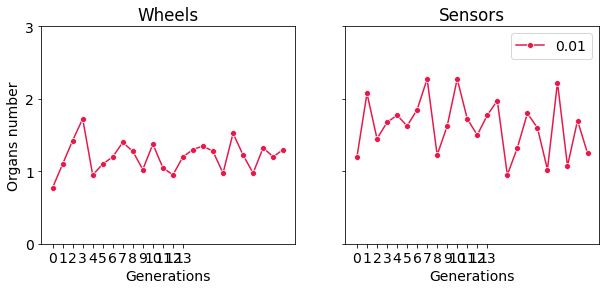

In [11]:
markers = ['o','>','o','>','o','>','o']
colours = [[230/255,25/255,75/255],[245/255,130/255,48/255],[255/255,255/255,25/255],[210/255,245/255,60/255],[60/255,180/255,75/255],[70/255,240/255,240/255],[0/255,130/255,200/255],[145/255,30/255,180/255],[240/255,50/255,230/255],[128/255,128/255,128/255],[0,0,0]]
colorIndex = [0,8,9,10]
# colorIndex = [0,6,10]
labels = []
for i in EXPERIMENTS:
    temp = str(int(i)/100)
    labels.append(temp)
    print(temp)
#fig = plt.figure(facecolor='white')
print(len(expDescriptors[0][0]))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = plt.gcf()
fig.set_size_inches(10, 4)
fig.set_facecolor('white')
exp_wheels = []
exp_sensors= []
for exp in range(len(EXPERIMENTS)):
    wheels = []
    sensors = []
    for i in range(REPLICATES):
        temp_gen_wheels = []
        temp_gen_sensors = []
        for j in range(0,EVALUATIONS,POPULATION):
            temp_gen_wheels.append(np.mean(expDescriptors[exp][i][j-POPULATION:j,5]))
            temp_gen_sensors.append(np.mean(expDescriptors[exp][i][j-POPULATION:j,6]))
        wheels.append(temp_gen_wheels)
        sensors.append(temp_gen_sensors)
    df_wheels = pd.DataFrame(wheels).melt()
    df_sensors = pd.DataFrame(sensors).melt()
    sns.lineplot(x="variable", y="value", data = df_wheels, ax=ax1, marker=markers[exp], color = colours[colorIndex[exp]])
    sns.lineplot(x="variable", y="value", data = df_sensors, ax=ax2, marker=markers[exp], color = colours[colorIndex[exp]])
    exp_wheels.append(wheels)
    exp_sensors.append(sensors)

for ax in fig.get_axes():
    ax.label_outer()

TICKPOS =  np.arange(0,4/16,1/16)
TICKLABEL = range(0,4,1)
ax1.set_yticks(TICKPOS)
ax2.set_yticks(TICKPOS)
ax1.set_yticklabels(TICKLABEL)
TICKLABEL = range(0,14,1)
TICKPOS = range(1,15,1)
ax1.set_xticks(TICKPOS)
ax1.set_xticklabels(TICKLABEL)
ax2.set_xticks(TICKPOS)
ax2.set_xticklabels(TICKLABEL)
ax1.set(xlabel="Generations", ylabel="Organs number")
ax2.set(xlabel="Generations")
# ax2.legend(EXPERIMENTS)
ax2.legend(labels)
ax1.set_title('Wheels')
ax2.set_title('Sensors')

plt.savefig(REPOSITORY+'/Prog.png',dpi=200, bbox_inches='tight')

In [12]:
from scipy.stats import mannwhitneyu
# print(bud_max_fitness[bud][0])

 
tempDat0 = np.array([[float(y) for y in x] for x in exp_wheels[0]])
tempDat1 = np.array([[float(y) for y in x] for x in exp_wheels[1]])
tempDat2 = np.array([[float(y) for y in x] for x in exp_wheels[2]])
tempDat3 = np.array([[float(y) for y in x] for x in exp_wheels[3]])

temp_list0 = []
temp_list1 = []
temp_list2 = []
for i in range(len(tempDat1[0])):
#     print(i)
    out0 = [x[i] for x in tempDat0]
    out1 = [x[i] for x in tempDat1]
    out2 = [x[i] for x in tempDat2]
    out3 = [x[i] for x in tempDat3]
#     print(len(out1))
    # print(tempDat[:][0])

    stat,p = mannwhitneyu(out0,out1)
#     print("---",p)
    #temp_list0.append(round(p, 3))
    temp_list0.append(p<0.05)
    stat,p = mannwhitneyu(out1,out2)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list1.append(p<0.05)
    stat,p = mannwhitneyu(out2,out3)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list2.append(p<0.05)
#     plt.plot(temp_list)
#     plt.ylim([0,1])
print(temp_list0)
print(temp_list1)
print(temp_list2)

IndexError: list index out of range

In [12]:
from scipy.stats import mannwhitneyu
# print(bud_max_fitness[bud][0])

 
tempDat0 = np.array([[float(y) for y in x] for x in exp_sensors[0]])
tempDat1 = np.array([[float(y) for y in x] for x in exp_sensors[1]])
tempDat2 = np.array([[float(y) for y in x] for x in exp_sensors[2]])
tempDat2 = np.array([[float(y) for y in x] for x in exp_sensors[3]])

temp_list0 = []
temp_list1 = []
temp_list2 = []
for i in range(len(tempDat1[0])):
#     print(i)
    out0 = [x[i] for x in tempDat0]
    out1 = [x[i] for x in tempDat1]
    out2 = [x[i] for x in tempDat2]
    out3 = [x[i] for x in tempDat3]
#     print(len(out1))
    # print(tempDat[:][0])

    stat,p = mannwhitneyu(out0,out1)
#     print("---",p)
    #temp_list0.append(round(p, 3))
    temp_list0.append(p<0.05)
    stat,p = mannwhitneyu(out1,out2)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list1.append(p<0.05)
    stat,p = mannwhitneyu(out2,out3)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list2.append(p<0.05)
#     plt.plot(temp_list)
#     plt.ylim([0,1])
print(temp_list0)
print(temp_list1)
print(temp_list2)

IndexError: list index out of range